So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 100
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 2

Example of what worked before
Vanilla Gumbel

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.025475
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.364727
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.813408
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.377846
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.789421
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.272232
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.735138
====> Epoch: 1 Average loss: 40.2637
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.667145
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.839146
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.290348
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.018883
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.494438
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.894810
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.304806
====> Epoch: 2 Average loss: 36.3581
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.488945
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.168549
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.825718
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.774975
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.973152
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.061474
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.331635
====> Epoch: 22 Average loss: 31.3046
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.464468
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.090925
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.385710
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.378185
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.083099
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.200535
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.603924
====> Epoch: 23 Average loss: 31.2617
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.427589
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.417957
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.155050
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.136375
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.301914
Train Epoch: 24 [6400/8000 (80%)]	Loss: 30.995852
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.024828
====> Epoch: 24 Average loss: 31.2183
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.158329
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.23723

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.737787
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.489750
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.354391
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.785429
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.513506
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.603989
====> Epoch: 44 Average loss: 30.5815
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.616575
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.918858
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.571480
Train Epoch: 45 [3840/8000 (48%)]	Loss: 29.968641
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.374784
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.382372
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.596666
====> Epoch: 45 Average loss: 30.5606
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.485878
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.495544
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.492105
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.522610
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.671391
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.361458
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.320505
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.630068
====> Epoch: 65 Average loss: 30.3213
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.300190
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.458065
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.408682
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.374939
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.282282
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.702181
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.307266
====> Epoch: 66 Average loss: 30.3194
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.609888
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.220716
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.086418
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.117208
Train Epoch: 67 [5120/8000 (64%)]	Loss: 29.990515
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.271574
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.390818
====> Epoch: 67 Average loss: 30.3145
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.23335

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.273878
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.167219
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.318243
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.263218
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.318445
Train Epoch: 87 [7680/8000 (96%)]	Loss: 30.046183
====> Epoch: 87 Average loss: 30.2171
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.000381
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.176579
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.217335
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.099638
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.219206
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.072548
Train Epoch: 88 [7680/8000 (96%)]	Loss: 29.983549
====> Epoch: 88 Average loss: 30.2128
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.087015
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.427864
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.551685
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.104860
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.130686
Train Epoch: 89 [6400/8000 (80%)

tensor(5628083., device='cuda:0')
tensor(574595.0625, device='cuda:0')


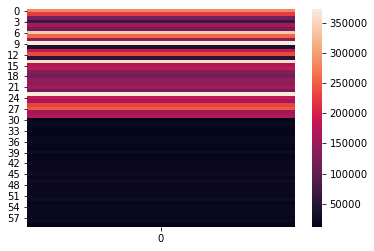

In [14]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(1608743.5000, device='cuda:0')
tensor(82154.2656, device='cuda:0')


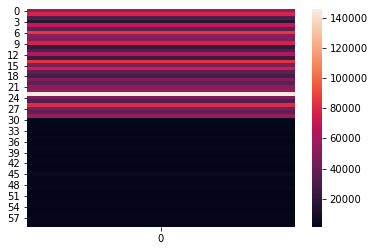

In [15]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(103116.8906, device='cuda:0')
tensor(19763.1074, device='cuda:0')


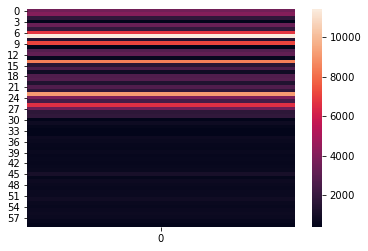

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(29652.0293, device='cuda:0')
tensor(1067.9706, device='cuda:0')


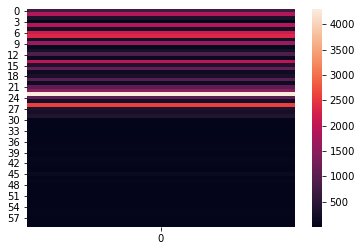

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(28584.0586, device='cuda:0')

**VAE_Gumbel_NInsta test here**

In [19]:
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [20]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.842697
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.322598
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.838947
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.225155
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.745399
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.170265
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.806061
====> Epoch: 1 Average loss: 40.1899
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.593357
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.953651
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.640877
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.841740
Train Epoch: 2 [5120/8000 (64%)]	Loss: 36.218555
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.682632
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.906414
====> Epoch: 2 Average loss: 36.7767
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.767715
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.255718
Train Epoch: 3 [2560/8000 (32%)]	Loss: 34.146069
Train Epoch: 3 [3840/8000 (48%)]	Loss: 34.116402
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.785587
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.539841
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.499285
====> Epoch: 22 Average loss: 31.4302
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.432377
Train Epoch: 23 [1280/8000 (16%)]	Loss: 30.862717
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.227655
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.161108
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.324219
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.525131
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.589808
====> Epoch: 23 Average loss: 31.3775
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.565836
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.488684
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.120375
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.368980
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.239153
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.355274
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.176809
====> Epoch: 24 Average loss: 31.3165
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.012562
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.34860

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.970974
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.642748
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.669577
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.495985
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.633831
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.710497
====> Epoch: 44 Average loss: 30.8275
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.910809
Train Epoch: 45 [1280/8000 (16%)]	Loss: 31.581474
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.748068
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.645756
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.578335
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.917831
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.844963
====> Epoch: 45 Average loss: 30.8095
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.904142
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.666357
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.649862
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.665712
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.897070
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.326595
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.213776
Train Epoch: 65 [7680/8000 (96%)]	Loss: 31.173655
====> Epoch: 65 Average loss: 30.6090
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.696453
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.816320
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.949230
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.746429
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.766823
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.693939
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.502178
====> Epoch: 66 Average loss: 30.5886
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.702744
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.595987
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.325071
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.347820
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.498127
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.585514
Train Epoch: 67 [7680/8000 (96%)]	Loss: 31.007132
====> Epoch: 67 Average loss: 30.6130
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.46271

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.821808
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.463961
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.597162
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.100637
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.641865
Train Epoch: 87 [7680/8000 (96%)]	Loss: 30.491962
====> Epoch: 87 Average loss: 30.5091
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.582762
Train Epoch: 88 [1280/8000 (16%)]	Loss: 31.027262
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.107672
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.639946
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.772213
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.577003
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.212551
====> Epoch: 88 Average loss: 30.5018
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.636253
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.716820
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.112583
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.371731
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.208408
Train Epoch: 89 [6400/8000 (80%)

tensor(5521402.5000, device='cuda:0')
tensor(367730.1875, device='cuda:0')


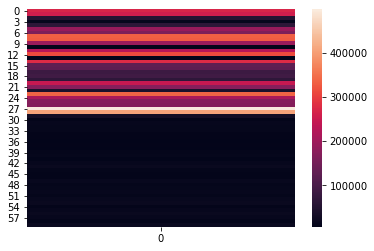

In [21]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(2012495.5000, device='cuda:0')
tensor(26636.2305, device='cuda:0')


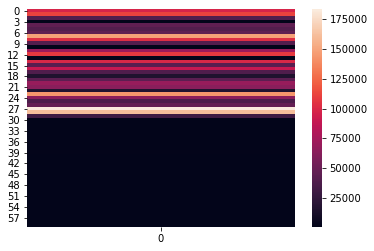

In [22]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(1595.5177, device='cuda:0')
tensor(324.4823, device='cuda:0')


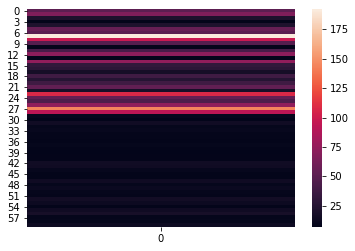

In [23]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(477.3168, device='cuda:0')
tensor(2.6832, device='cuda:0')


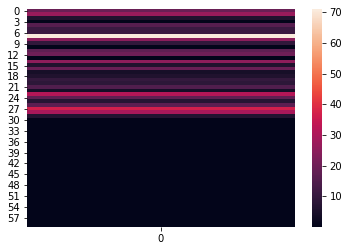

In [24]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [25]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(474.6335, device='cuda:0')

**Global Set of Subset Logits**

In [57]:
vae_gumbel_truncated = VAE_Gumbel_GlobalGate(2*D, 100, 20, k = 3*z_size, t = 4)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                              lr=lr, 
                                              betas = (b1,b2))



In [58]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, 300+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.805199
Train Epoch: 1 [1280/8000 (16%)]	Loss: 42.099007
Train Epoch: 1 [2560/8000 (32%)]	Loss: 41.501057
Train Epoch: 1 [3840/8000 (48%)]	Loss: 41.018154
Train Epoch: 1 [5120/8000 (64%)]	Loss: 40.476456
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.936161
Train Epoch: 1 [7680/8000 (96%)]	Loss: 39.465649
====> Epoch: 1 Average loss: 40.9580
Train Epoch: 2 [0/8000 (0%)]	Loss: 39.406082
Train Epoch: 2 [1280/8000 (16%)]	Loss: 38.662628
Train Epoch: 2 [2560/8000 (32%)]	Loss: 38.174374
Train Epoch: 2 [3840/8000 (48%)]	Loss: 37.124466
Train Epoch: 2 [5120/8000 (64%)]	Loss: 36.287128
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.689323
Train Epoch: 2 [7680/8000 (96%)]	Loss: 35.199345
====> Epoch: 2 Average loss: 37.1408
Train Epoch: 3 [0/8000 (0%)]	Loss: 35.169655
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.667747
Train Epoch: 3 [2560/8000 (32%)]	Loss: 34.347649
Train Epoch: 3 [3840/8000 (48%)]	Loss: 34.011772
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.857555
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.496305
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.447590
====> Epoch: 22 Average loss: 31.5509
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.396200
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.540819
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.629293
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.715477
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.046211
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.274225
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.459299
====> Epoch: 23 Average loss: 31.4611
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.546642
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.558451
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.788906
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.584257
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.268641
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.250658
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.532846
====> Epoch: 24 Average loss: 31.3944
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.745832
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.56613

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.805548
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.812561
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.719549
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.606718
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.667313
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.550079
====> Epoch: 44 Average loss: 30.7993
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.872707
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.780712
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.911406
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.915390
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.544388
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.668749
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.630823
====> Epoch: 45 Average loss: 30.7806
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.997147
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.711735
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.739601
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.884295
Train Epoch: 46 [5120/8000 (64%)]	Loss: 31.028692
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.973032
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.666922
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.908794
====> Epoch: 65 Average loss: 30.6009
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.763958
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.499559
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.343918
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.763548
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.715847
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.519775
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.179180
====> Epoch: 66 Average loss: 30.5925
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.657734
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.473499
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.570271
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.863735
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.721371
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.387970
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.298830
====> Epoch: 67 Average loss: 30.5837
Train Epoch: 68 [0/8000 (0%)]	Loss: 31.19488

Train Epoch: 86 [7680/8000 (96%)]	Loss: 30.261238
====> Epoch: 86 Average loss: 30.4814
Train Epoch: 87 [0/8000 (0%)]	Loss: 30.560604
Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.270500
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.564398
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.513279
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.183134
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.402527
Train Epoch: 87 [7680/8000 (96%)]	Loss: 30.245594
====> Epoch: 87 Average loss: 30.4715
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.511530
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.523363
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.484936
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.746971
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.007822
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.142450
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.302319
====> Epoch: 88 Average loss: 30.4767
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.561661
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.284569
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.39575

Train Epoch: 108 [1280/8000 (16%)]	Loss: 30.667236
Train Epoch: 108 [2560/8000 (32%)]	Loss: 30.363731
Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.210428
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.507063
Train Epoch: 108 [6400/8000 (80%)]	Loss: 30.242340
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.406681
====> Epoch: 108 Average loss: 30.3717
Train Epoch: 109 [0/8000 (0%)]	Loss: 30.472851
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.668743
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.807764
Train Epoch: 109 [3840/8000 (48%)]	Loss: 30.449781
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.357594
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.454407
Train Epoch: 109 [7680/8000 (96%)]	Loss: 30.579624
====> Epoch: 109 Average loss: 30.3872
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.422117
Train Epoch: 110 [1280/8000 (16%)]	Loss: 30.513508
Train Epoch: 110 [2560/8000 (32%)]	Loss: 30.386662
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.202042
Train Epoch: 110 [5120/8000 (64%)]	Loss: 30.469244
Train Epoch:

Train Epoch: 129 [1280/8000 (16%)]	Loss: 30.626150
Train Epoch: 129 [2560/8000 (32%)]	Loss: 30.448204
Train Epoch: 129 [3840/8000 (48%)]	Loss: 30.237507
Train Epoch: 129 [5120/8000 (64%)]	Loss: 30.128214
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.697197
Train Epoch: 129 [7680/8000 (96%)]	Loss: 30.500469
====> Epoch: 129 Average loss: 30.3433
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.373915
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.014772
Train Epoch: 130 [2560/8000 (32%)]	Loss: 30.283667
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.357798
Train Epoch: 130 [5120/8000 (64%)]	Loss: 30.279192
Train Epoch: 130 [6400/8000 (80%)]	Loss: 30.219582
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.075602
====> Epoch: 130 Average loss: 30.3430
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.513180
Train Epoch: 131 [1280/8000 (16%)]	Loss: 30.269115
Train Epoch: 131 [2560/8000 (32%)]	Loss: 30.120676
Train Epoch: 131 [3840/8000 (48%)]	Loss: 30.026291
Train Epoch: 131 [5120/8000 (64%)]	Loss: 30.185181
Train Epoch:

Train Epoch: 150 [1280/8000 (16%)]	Loss: 30.422934
Train Epoch: 150 [2560/8000 (32%)]	Loss: 30.250380
Train Epoch: 150 [3840/8000 (48%)]	Loss: 30.391718
Train Epoch: 150 [5120/8000 (64%)]	Loss: 30.845911
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.460781
Train Epoch: 150 [7680/8000 (96%)]	Loss: 30.343721
====> Epoch: 150 Average loss: 30.3692
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.526756
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.493080
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.691561
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.392588
Train Epoch: 151 [5120/8000 (64%)]	Loss: 30.309660
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.833426
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.494125
====> Epoch: 151 Average loss: 30.3232
Train Epoch: 152 [0/8000 (0%)]	Loss: 30.510071
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.184193
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.147514
Train Epoch: 152 [3840/8000 (48%)]	Loss: 30.437788
Train Epoch: 152 [5120/8000 (64%)]	Loss: 30.762377
Train Epoch:

Train Epoch: 171 [1280/8000 (16%)]	Loss: 30.436563
Train Epoch: 171 [2560/8000 (32%)]	Loss: 30.109343
Train Epoch: 171 [3840/8000 (48%)]	Loss: 30.446365
Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.117191
Train Epoch: 171 [6400/8000 (80%)]	Loss: 30.718628
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.298723
====> Epoch: 171 Average loss: 30.3824
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.205349
Train Epoch: 172 [1280/8000 (16%)]	Loss: 30.238110
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.533657
Train Epoch: 172 [3840/8000 (48%)]	Loss: 30.338158
Train Epoch: 172 [5120/8000 (64%)]	Loss: 30.382999
Train Epoch: 172 [6400/8000 (80%)]	Loss: 30.552130
Train Epoch: 172 [7680/8000 (96%)]	Loss: 30.669678
====> Epoch: 172 Average loss: 30.3820
Train Epoch: 173 [0/8000 (0%)]	Loss: 30.052715
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.267420
Train Epoch: 173 [2560/8000 (32%)]	Loss: 30.168406
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.539097
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.590578
Train Epoch:

Train Epoch: 192 [1280/8000 (16%)]	Loss: 30.399698
Train Epoch: 192 [2560/8000 (32%)]	Loss: 30.385950
Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.292971
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.669806
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.330074
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.327976
====> Epoch: 192 Average loss: 30.4002
Train Epoch: 193 [0/8000 (0%)]	Loss: 30.288229
Train Epoch: 193 [1280/8000 (16%)]	Loss: 30.057642
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.345234
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.331451
Train Epoch: 193 [5120/8000 (64%)]	Loss: 30.892742
Train Epoch: 193 [6400/8000 (80%)]	Loss: 30.994102
Train Epoch: 193 [7680/8000 (96%)]	Loss: 30.102501
====> Epoch: 193 Average loss: 30.3807
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.330187
Train Epoch: 194 [1280/8000 (16%)]	Loss: 30.179295
Train Epoch: 194 [2560/8000 (32%)]	Loss: 30.690155
Train Epoch: 194 [3840/8000 (48%)]	Loss: 30.761822
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.452503
Train Epoch:

Train Epoch: 213 [1280/8000 (16%)]	Loss: 30.562344
Train Epoch: 213 [2560/8000 (32%)]	Loss: 30.298626
Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.717682
Train Epoch: 213 [5120/8000 (64%)]	Loss: 30.166197
Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.054216
Train Epoch: 213 [7680/8000 (96%)]	Loss: 30.243448
====> Epoch: 213 Average loss: 30.4207
Train Epoch: 214 [0/8000 (0%)]	Loss: 30.447948
Train Epoch: 214 [1280/8000 (16%)]	Loss: 30.414904
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.367212
Train Epoch: 214 [3840/8000 (48%)]	Loss: 30.303286
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.117308
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.379101
Train Epoch: 214 [7680/8000 (96%)]	Loss: 30.570333
====> Epoch: 214 Average loss: 30.4397
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.516172
Train Epoch: 215 [1280/8000 (16%)]	Loss: 31.079634
Train Epoch: 215 [2560/8000 (32%)]	Loss: 30.334988
Train Epoch: 215 [3840/8000 (48%)]	Loss: 30.389114
Train Epoch: 215 [5120/8000 (64%)]	Loss: 30.386198
Train Epoch:

Train Epoch: 234 [1280/8000 (16%)]	Loss: 30.510326
Train Epoch: 234 [2560/8000 (32%)]	Loss: 30.423445
Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.277241
Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.629158
Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.462934
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.385805
====> Epoch: 234 Average loss: 30.4247
Train Epoch: 235 [0/8000 (0%)]	Loss: 30.496643
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.808418
Train Epoch: 235 [2560/8000 (32%)]	Loss: 30.530149
Train Epoch: 235 [3840/8000 (48%)]	Loss: 30.265898
Train Epoch: 235 [5120/8000 (64%)]	Loss: 30.367092
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.241920
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.471498
====> Epoch: 235 Average loss: 30.4008
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.819794
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.580063
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.879936
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.162958
Train Epoch: 236 [5120/8000 (64%)]	Loss: 30.176123
Train Epoch:

Train Epoch: 255 [1280/8000 (16%)]	Loss: 30.175802
Train Epoch: 255 [2560/8000 (32%)]	Loss: 30.408964
Train Epoch: 255 [3840/8000 (48%)]	Loss: 30.186192
Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.399052
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.583216
Train Epoch: 255 [7680/8000 (96%)]	Loss: 31.130674
====> Epoch: 255 Average loss: 30.3928
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.208370
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.214441
Train Epoch: 256 [2560/8000 (32%)]	Loss: 30.451000
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.083630
Train Epoch: 256 [5120/8000 (64%)]	Loss: 30.447725
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.223675
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.061052
====> Epoch: 256 Average loss: 30.3838
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.325377
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.330185
Train Epoch: 257 [2560/8000 (32%)]	Loss: 30.987728
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.250610
Train Epoch: 257 [5120/8000 (64%)]	Loss: 30.343105
Train Epoch:

Train Epoch: 276 [1280/8000 (16%)]	Loss: 30.355944
Train Epoch: 276 [2560/8000 (32%)]	Loss: 30.260492
Train Epoch: 276 [3840/8000 (48%)]	Loss: 30.410992
Train Epoch: 276 [5120/8000 (64%)]	Loss: 30.155914
Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.088114
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.605112
====> Epoch: 276 Average loss: 30.3753
Train Epoch: 277 [0/8000 (0%)]	Loss: 29.909170
Train Epoch: 277 [1280/8000 (16%)]	Loss: 30.407743
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.555302
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.237619
Train Epoch: 277 [5120/8000 (64%)]	Loss: 30.986998
Train Epoch: 277 [6400/8000 (80%)]	Loss: 30.209404
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.434795
====> Epoch: 277 Average loss: 30.3902
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.042227
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.495657
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.097403
Train Epoch: 278 [3840/8000 (48%)]	Loss: 30.336258
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.556913
Train Epoch:

Train Epoch: 297 [1280/8000 (16%)]	Loss: 30.202288
Train Epoch: 297 [2560/8000 (32%)]	Loss: 30.620136
Train Epoch: 297 [3840/8000 (48%)]	Loss: 30.558563
Train Epoch: 297 [5120/8000 (64%)]	Loss: 30.509665
Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.697342
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.792385
====> Epoch: 297 Average loss: 30.3734
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.249313
Train Epoch: 298 [1280/8000 (16%)]	Loss: 30.338549
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.987701
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.492882
Train Epoch: 298 [5120/8000 (64%)]	Loss: 30.497118
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.052713
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.137213
====> Epoch: 298 Average loss: 30.3598
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.203115
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.201805
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.451887
Train Epoch: 299 [3840/8000 (48%)]	Loss: 29.955603
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.154228
Train Epoch:

tensor(195398.4219, device='cuda:0')
tensor(23611.6016, device='cuda:0')


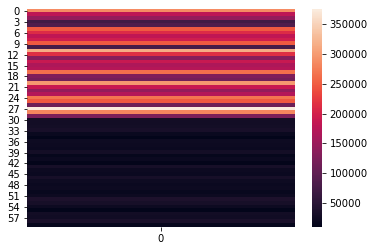

In [59]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(1040663.9375, device='cuda:0')
tensor(30412.4590, device='cuda:0')


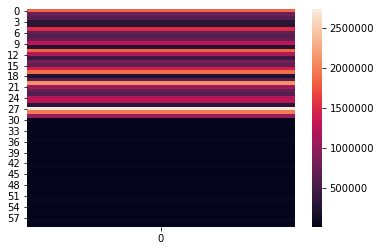

In [60]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(1040.6177, device='cuda:0')
tensor(879.3823, device='cuda:0')


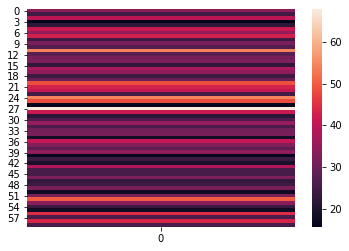

In [61]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(3964.9478, device='cuda:0')
tensor(1315.0524, device='cuda:0')


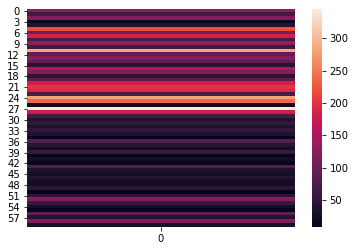

In [62]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [63]:
subset_indices_post_burnin[:(D)]

tensor([126.5326,  67.2138, 117.8094,  17.5399,  40.2813, 220.9812, 106.8487,
        184.8667,  68.8697, 133.7836,  64.4774, 284.2991,  91.1132, 121.8528,
         92.9152,  41.7170, 155.5827, 119.9319,  44.6025,  85.2170, 181.0041,
        202.0221, 190.6108,  70.3642, 282.3073, 237.7163,  22.3356, 344.4826,
        179.0376,  68.6314], device='cuda:0')

In [64]:
subset_indices_post_burnin[(D):]

tensor([ 36.4166,  52.5715,  34.3625,  52.9541,  38.2306,  11.8907,  80.3713,
         44.4265,  25.2110,  56.3978,   8.5551,  27.9950,  13.0017,  80.3650,
         33.8422,  26.3513,  40.7182,  25.2696,  25.5978,  47.5173,  10.0271,
         47.9736, 120.4587,  59.6486,  27.5901,  10.6630,  91.9775,  38.7812,
        114.8945,  30.9922], device='cuda:0')

In [65]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2649.8955, device='cuda:0')

In [66]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1), 
                        descending = True)[:vae_gumbel_truncated.k]

In [67]:
sum(top_ind < 30)

tensor(17, device='cuda:0')

In [68]:
sum(top_ind >= 30)

tensor(7, device='cuda:0')

In [69]:
vae_gumbel_truncated.logit_enc

Parameter containing:
tensor([[ 0.6880, -0.0543,  0.4419, -1.1146, -0.6016,  1.3430,  0.3509,  1.1525,
          0.0085,  0.8729, -0.1108,  1.9034,  0.3704,  0.5080,  0.2548, -0.4513,
          1.0382,  0.2645, -0.5386,  0.1384,  0.9705,  1.0880,  1.1933, -0.0941,
          2.0168,  1.3659, -1.0958,  2.5181,  1.2097, -0.0362, -1.2583, -0.8277,
         -1.2835, -0.8813, -1.0872, -2.0131, -0.5063, -1.1594, -1.3300, -0.7936,
         -2.1289, -1.4841, -1.8820, -0.6036, -1.3859, -1.3975, -1.0654, -1.4052,
         -1.4398, -1.0197, -2.0334, -1.0630, -0.2221, -0.7511, -1.3352, -2.0147,
         -0.4364, -1.2458, -0.3509, -1.3291]], device='cuda:0',
       requires_grad=True)

In [70]:
sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t)



tensor([[1.2082e+00, 1.0724e+00, 3.1210e-01, 2.4660e-02, 7.1276e-01, 1.1994e+00,
         1.2878e-01, 9.3383e-01, 2.2951e-08, 1.7870e-02, 1.3099e-01, 1.9189e+00,
         1.0380e+00, 6.1129e-01, 9.3221e-01, 6.5186e-04, 1.8321e+00, 2.1633e-02,
         2.0177e-03, 6.2031e-01, 1.0724e+00, 1.4038e+00, 1.9388e+00, 8.7977e-07,
         9.9227e-01, 1.5345e+00, 4.4241e-06, 1.2297e+00, 7.2163e-01, 9.7542e-12,
         1.7502e-03, 5.6541e-02, 1.0606e-05, 9.8373e-01, 2.4754e-03, 2.6402e-08,
         5.2108e-07, 5.4035e-07, 9.8877e-07, 7.9795e-08, 4.5595e-09, 7.8109e-10,
         6.0446e-11, 4.8623e-03, 1.6338e-03, 9.1767e-06, 1.6378e-01, 1.2909e-09,
         7.1800e-06, 5.2182e-08, 3.1590e-06, 1.4877e-07, 8.1734e-06, 1.3539e-02,
         4.0524e-01, 3.4663e-03, 7.5120e-01, 5.0173e-05, 4.6404e-06, 3.3335e-04]],
       device='cuda:0', grad_fn=<SumBackward1>)

**Running Mean of Logits**

In [40]:
vae_gumbel_truncated = VAE_Gumbel_RunningState(2*D, 100, 20, k = 3*z_size, t = global_t, alpha = 0.9)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                              lr=lr, 
                                              betas = (b1,b2))



In [41]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size,
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

vae_gumbel_truncated.set_burned_in()

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.794140
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.309376
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.732067
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.141937
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.758877
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.247311
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.726837
====> Epoch: 1 Average loss: 40.1887
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.541740
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.952629
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.249638
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.181366
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.719643
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.947742
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.786247
====> Epoch: 2 Average loss: 36.4013
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.610420
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.292969
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.893204
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.439472
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.646011
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.431074
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.361799
====> Epoch: 22 Average loss: 31.4798
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.737314
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.668776
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.230858
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.181168
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.464647
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.259491
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.183348
====> Epoch: 23 Average loss: 31.3960
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.392061
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.078444
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.309837
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.208694
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.852125
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.195761
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.299992
====> Epoch: 24 Average loss: 31.3168
Train Epoch: 25 [0/8000 (0%)]	Loss: 30.949738
Train Epoch: 25 [1280/8000 (16%)]	Loss: 30.97585

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.666626
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.700764
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.854816
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.393913
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.813421
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.878084
====> Epoch: 44 Average loss: 30.7745
Train Epoch: 45 [0/8000 (0%)]	Loss: 31.082809
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.747206
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.377165
Train Epoch: 45 [3840/8000 (48%)]	Loss: 31.031412
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.941559
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.855560
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.359175
====> Epoch: 45 Average loss: 30.7781
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.288162
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.845238
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.966570
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.827301
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.652517
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.305830
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.608896
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.728050
====> Epoch: 65 Average loss: 30.5965
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.573114
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.691334
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.673372
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.819300
Train Epoch: 66 [5120/8000 (64%)]	Loss: 31.035391
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.583416
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.488060
====> Epoch: 66 Average loss: 30.6103
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.568451
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.944414
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.438725
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.999842
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.956553
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.524725
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.469923
====> Epoch: 67 Average loss: 30.6007
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.85832

Train Epoch: 86 [7680/8000 (96%)]	Loss: 30.799658
====> Epoch: 86 Average loss: 30.5385
Train Epoch: 87 [0/8000 (0%)]	Loss: 30.527761
Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.403286
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.332474
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.291218
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.293461
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.700022
Train Epoch: 87 [7680/8000 (96%)]	Loss: 30.669409
====> Epoch: 87 Average loss: 30.5260
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.260584
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.540585
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.607517
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.815191
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.228334
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.512245
Train Epoch: 88 [7680/8000 (96%)]	Loss: 31.371115
====> Epoch: 88 Average loss: 30.5271
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.661898
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.531233
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.43593

tensor(192572.7031, device='cuda:0')
tensor(12001.9531, device='cuda:0')


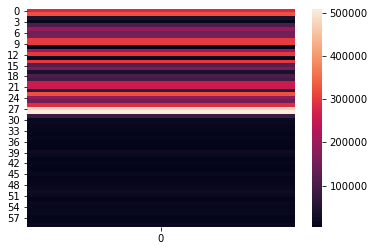

In [42]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(71594.3125, device='cuda:0')
tensor(156.3959, device='cuda:0')


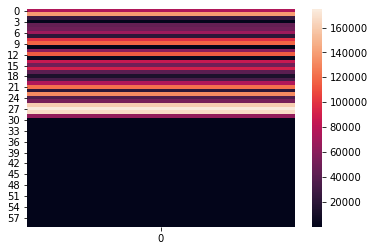

In [43]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(1571.5201, device='cuda:0')
tensor(348.4799, device='cuda:0')


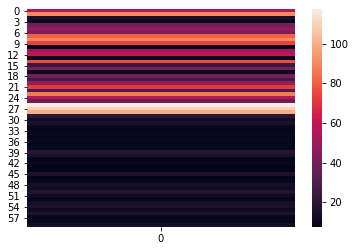

In [44]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(477.3334, device='cuda:0')
tensor(2.6665, device='cuda:0')


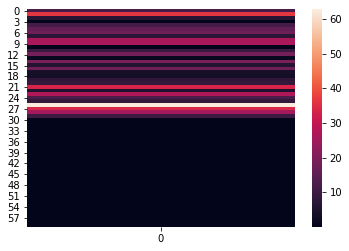

In [45]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [46]:
subset_indices_post_burnin[:(D)]

tensor([12.0112, 36.3037,  6.6490,  0.0843, 11.4010, 15.7938, 17.6403,  7.3298,
        26.2643, 26.2097,  0.1118,  9.8009, 18.8652,  1.3889, 19.7005,  6.0710,
        17.6546,  3.9792,  3.3889,  8.0732,  8.6785, 33.8325,  5.1983, 27.4494,
        12.4186,  8.7436, 62.7337, 33.9175, 25.6976,  9.9424], device='cuda:0')

In [47]:
subset_indices_post_burnin[(D):]

tensor([0.0794, 0.0944, 0.1157, 0.1433, 0.1060, 0.2191, 0.0436, 0.0566, 0.0557,
        0.0810, 0.0585, 0.0926, 0.0390, 0.0554, 0.0956, 0.0768, 0.0788, 0.0648,
        0.1225, 0.0621, 0.1149, 0.1013, 0.0724, 0.0779, 0.0989, 0.0910, 0.0596,
        0.0879, 0.0861, 0.1355], device='cuda:0')

In [48]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1), 
                        descending = True)[:vae_gumbel_truncated.k]

In [49]:
sum(top_ind < 30)

tensor(24, device='cuda:0')

In [50]:
sum(top_ind >= 30)

tensor(0, device='cuda:0')

See if the latest mean and the running mean are similar

In [51]:
vae_gumbel_truncated.weight_creator(train_data[64:128, ]).mean(dim = 0)

tensor([ 4.5483e+00,  6.6549e+00,  3.6794e+00, -1.7396e-01,  4.6551e+00,
         4.4036e+00,  5.0864e+00,  3.7830e+00,  5.9193e+00,  5.7613e+00,
        -6.6588e-02,  4.3437e+00,  5.4353e+00,  2.2419e+00,  5.3794e+00,
         4.1865e+00,  5.4834e+00,  3.9366e+00,  3.4776e+00,  4.1027e+00,
         4.1008e+00,  6.3858e+00,  3.7579e+00,  6.6471e+00,  4.1263e+00,
         4.3616e+00,  1.0990e+01,  6.3616e+00,  5.9921e+00,  4.2407e+00,
        -1.2367e-02, -2.6724e-03, -2.4123e-02, -9.5892e-02, -5.0182e-02,
         2.1577e-03, -7.2614e-03, -8.0894e-02, -1.3215e-01, -4.6087e-03,
        -5.7626e-03, -1.2516e-01, -1.1413e-02, -1.1118e-01, -7.3719e-02,
        -6.8894e-03, -1.6260e-01, -3.0522e-02, -2.8417e-02, -8.9838e-03,
        -1.5316e-03, -9.2460e-03, -8.4703e-02, -1.0527e-02, -1.1578e-02,
        -9.6805e-03, -1.0379e-02, -1.4197e-01, -8.7980e-02, -4.5179e-03],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [52]:
vae_gumbel_truncated.logit_enc

Parameter containing:
tensor([[ 4.5593e+00,  6.6738e+00,  3.6751e+00, -1.7398e-01,  4.6680e+00,
          4.4328e+00,  5.0952e+00,  3.7705e+00,  5.8868e+00,  5.7132e+00,
         -6.6454e-02,  4.3520e+00,  5.4098e+00,  2.2345e+00,  5.3648e+00,
          4.1950e+00,  5.4727e+00,  3.9060e+00,  3.4391e+00,  4.1158e+00,
          4.1091e+00,  6.4050e+00,  3.7872e+00,  6.6376e+00,  4.1280e+00,
          4.3398e+00,  1.0982e+01,  6.3865e+00,  5.9933e+00,  4.2438e+00,
         -1.2296e-02, -2.6179e-03, -2.3911e-02, -9.5689e-02, -5.0118e-02,
          2.0099e-03, -7.1971e-03, -8.0578e-02, -1.3202e-01, -4.5458e-03,
         -5.6338e-03, -1.2520e-01, -1.1372e-02, -1.1095e-01, -7.3248e-02,
         -6.8301e-03, -1.6216e-01, -3.0394e-02, -2.8274e-02, -8.9443e-03,
         -1.4459e-03, -9.1508e-03, -8.4654e-02, -1.0495e-02, -1.1521e-02,
         -9.5102e-03, -1.0258e-02, -1.4173e-01, -8.7658e-02, -4.4585e-03]],
       device='cuda:0')

In [53]:
sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t)


tensor([[1.4553e-01, 1.7971e+00, 7.8468e-01, 1.6520e-04, 4.7666e-01, 1.0362e+00,
         1.3893e+00, 5.4687e-02, 1.5010e+00, 1.8101e+00, 1.0719e-03, 1.5367e-01,
         6.4521e-01, 2.6775e-02, 5.6307e-02, 7.2343e-01, 1.4276e-01, 8.0278e-01,
         2.9069e-03, 3.7434e-01, 1.8883e-01, 1.2174e+00, 4.1484e-01, 2.6825e+00,
         3.5530e-01, 1.0063e+00, 3.2867e+00, 5.7336e-01, 1.0914e+00, 1.1500e+00,
         1.9110e-03, 3.3586e-05, 1.3780e-03, 1.3484e-03, 1.3384e-03, 7.3225e-04,
         2.1849e-04, 9.2854e-03, 5.8104e-03, 1.4612e-02, 3.6917e-06, 1.2171e-03,
         2.4028e-03, 3.4504e-04, 1.9887e-03, 1.1408e-03, 2.9421e-03, 9.4520e-04,
         4.6923e-03, 4.3440e-03, 1.5095e-03, 7.5243e-03, 2.8754e-04, 4.1667e-03,
         9.9681e-03, 1.2497e-02, 2.9659e-03, 1.7660e-05, 3.5081e-03, 9.5781e-03]],
       device='cuda:0')

In [54]:
vae_gumbel_truncated

VAE_Gumbel_RunningState(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): Sigmoid()
  )
  (weight_creator): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

In [55]:
for e in vae_gumbel_truncated.named_parameters():
    print(e[0])

logit_enc
encoder.0.weight
encoder.0.bias
enc_mean.weight
enc_mean.bias
enc_logvar.weight
enc_logvar.bias
decoder.0.weight
decoder.0.bias
decoder.2.weight
decoder.2.bias
weight_creator.0.weight
weight_creator.0.bias
weight_creator.2.weight
weight_creator.2.bias


In [56]:
torch.save(vae_gumbel_truncated.state_dict(), "~/Downloads/tmp_model.pt")


FileNotFoundError: [Errno 2] No such file or directory: '~/Downloads/tmp_model.pt'

In [ ]:
model = VAE_Gumbel_RunningState(2*D, 100, 20, k = 3*z_size, t = global_t, alpha = 0.9)
model.logit_enc = nn.Parameter(torch.zeros(2*D).view(1, -1))
model.to(device)
for e in model.named_parameters():
    print(e[0])
model.load_state_dict(torch.load("~/Downloads/tmp_model.pt"))
model.eval()

